<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook solves the polar heat equation in one dimension

$\rho c \frac{\partial T}{\partial t}=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

With the assumption that $\frac{\partial k}{\partial r} = 0$, the equation simplifies to

$\rho c \frac{\partial T}{\partial t}=\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

The initial condition is linearly interpolated from the measured core and bark temperatures at $t = 0$. Two boundary conditions are from the measured core and bark temperatures.

We aim to solve the inverse problem for determining the parameters in the original continuous PDE.

The inverse problem is formulated to be

$\frac{\partial T}{\partial t}=\lambda_1\frac{\partial T}{\partial r}+\lambda_2\frac{\partial^2 T}{\partial r^2}+\lambda_3$

and the Physics information is

$\text{residual} = \frac{\partial T}{\partial t}-\lambda_1\frac{\partial T}{\partial r}-\lambda_2\frac{\partial^2 T}{\partial r^2}-\lambda_3$


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas
from time import time

Set hyperparameters

In [2]:
# set data type and hyperparameters
# import data

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

EPOCH = 5000

# Set number of data points
N_0 = 411 # number of points in space
N_b = 411 # number of points in time
N_r = 100000

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.
xmax = 0.135

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- we compare left and right boundary at give time steps.
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

In [3]:
##### measured tree temperature for initial and boundary conditions. Need fixing
colnames_tree_temp = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames_tree_temp)

##### ave tree temp and weather temp for future reference
train_tree_temp_index = 416 - 2

train_interp_temp_size = train_tree_temp_index
test_tree_temp_index = 827 - 2
train_interp_temp_size = train_tree_temp_index
test_interp_temp_size = test_tree_temp_index - train_tree_temp_index

# train_weather_index = 145 - 2
# test_weather_index = 289 -2
# train_interp_weather_size = train_weather_index
# test_interp_weather_size = test_weather_index - train_weather_index
#####

### Initial and boundary conditions
# core temp is west, at 13.5cm, at 2m high
test_coreTemp = np.array(dataTemp.s135_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
test_midTemp1 = np.array(dataTemp.w9_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
test_midTemp2 = np.array(dataTemp.n45_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
test_barkTemp = np.array(dataTemp.w_ext_35[train_tree_temp_index: test_tree_temp_index])+ 273.15

initTemp = np.array([test_coreTemp[0], test_midTemp1[0], test_midTemp2[0], test_barkTemp[0]])
init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,initTemp.size),initTemp)

Rename variables to be easy to read.

In [4]:
u_0 = init_temp
u_lb = test_coreTemp
u_ub = test_barkTemp

# collect initial and boundary data in lists
X_data = [X_0, X_lb, X_ub]
u_data = [u_0, u_lb, u_ub]

Text(0.5, 1.0, 'Boundary temperature at the core')

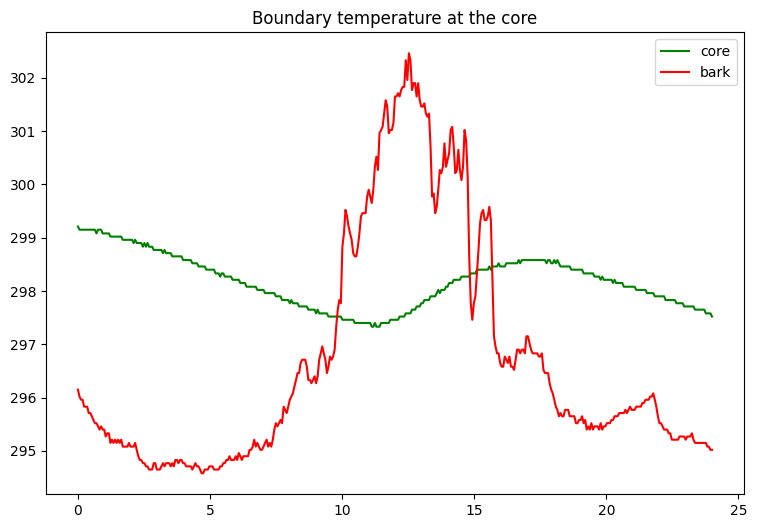

In [5]:
# visualize the boundary conditions.
fig1 = plt.figure(figsize=(9,6))
plt.plot(t_b, u_lb, color='green', label='core')
plt.plot(t_b, u_ub, color='red', label='bark')
plt.legend()
plt.title("Boundary temperature at the core")

Text(0.5, 1.0, 'Initial temperature distribution in tree trunk')

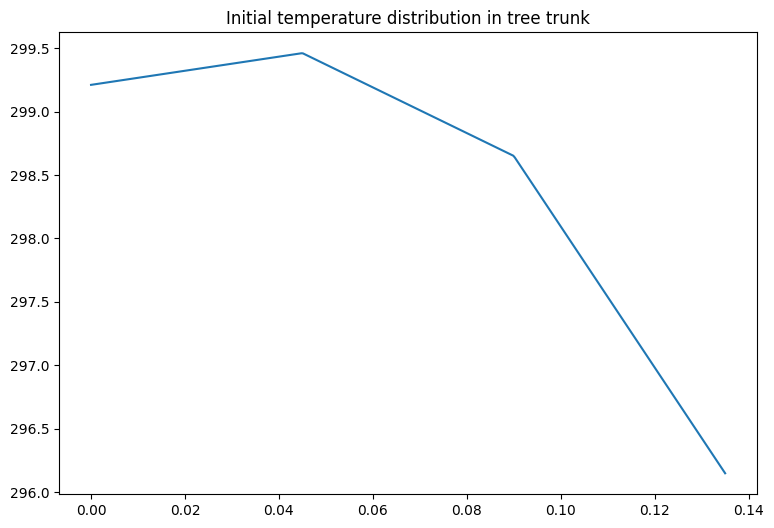

In [6]:
# visualize the initial condition.
fig2 = plt.figure(figsize=(9,6))
plt.plot(x_0, u_0, label = 'initial temp')
plt.legend
plt.title("Initial temperature distribution in tree trunk")

Plot initial and boundary data, and collocation data in time space.

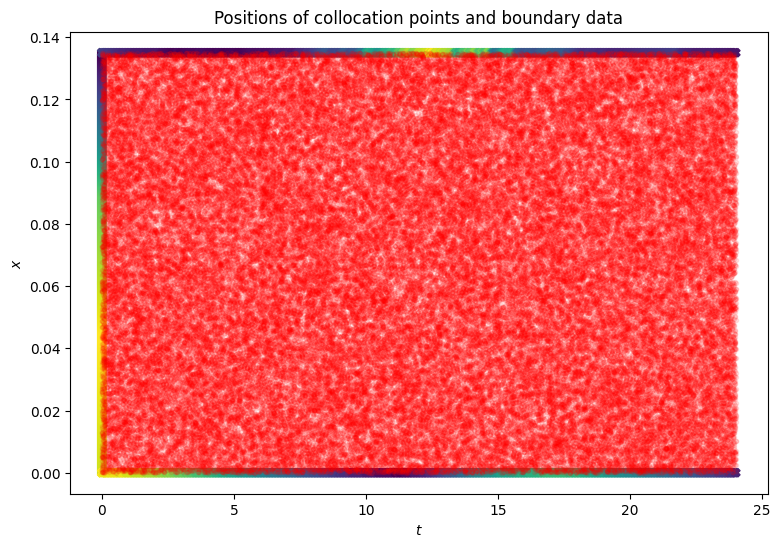

In [7]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=u_0.min(), vmax=u_0.max())
plt.scatter(t_b, x_lb, c=u_lb, marker='X', vmin=u_lb.min(), vmax=u_lb.max())
plt.scatter(t_b, x_ub, c=u_ub, marker='X', vmin=u_ub.min(), vmax=u_ub.max())
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_heat.pdf', bbox_inches='tight', dpi=300)

Class implementation of PINN. Derive `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`. This is a general neural net that is equation independent.

In [8]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim
    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

Derive from the above neural net class to take in additional parameters `lambd1`, `lambd2`, `lambd3`.

In [9]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        self.lambd1 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd2_list = []

        self.lambd3 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd3_list = []

Define base class `PINNSolver`. This is equation dependent. Components to customize are

1. get_r <---- modify what derivatives are computed
2. loss_fn <--- modify the boundary conditions
3. fun_r <--- residual of the PDE
4. should check all functions if boundary data were changed

Here we only consider the method based on tensorflow optimizer object as input. The [original notebook](https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=wcOkamgfZEks) though, also has method based on SciPy's LBFGS method.

In [10]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx) ########


    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss


    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g


    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t - self.model.lambd1 * u_x - self.model.lambd2 * u_xx - self.model.lambd3

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        lambd3 = self.model.lambd3.numpy()
        self.model.lambd3_list.append(lambd3)

        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e} lambda3 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2,lambd3))

        self.hist.append(self.current_loss)
        self.iter += 1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_{\theta(t,x)$}')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.plot(range(len(self.hist)), self.model.lambd3_list,'-',color='tab:green')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

Initialize model and solver.

In [11]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,2))

# initialize PINN solver
solver = PINNSolver(model, X_r)

Start training

In [12]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# start timer
t0 = time()
solver.solve_with_TFoptimizer(optim, X_data, u_data, N=4001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.66050719e+05 lambda1 = 9.90000069e-01 lambda2 = 9.90000069e-01 lambda3 = 9.90000069e-01
It 00050: loss = 2.38970844e+05 lambda1 = 1.35188472e+00 lambda2 = 6.80711627e-01 lambda3 = 1.36539507e+00
It 00100: loss = 2.17991547e+05 lambda1 = 1.38271308e+00 lambda2 = 6.63118005e-01 lambda3 = 1.32754636e+00
It 00150: loss = 2.00131375e+05 lambda1 = 1.38365483e+00 lambda2 = 6.65603518e-01 lambda3 = 1.19524896e+00
It 00200: loss = 1.83952469e+05 lambda1 = 1.38434923e+00 lambda2 = 6.67886555e-01 lambda3 = 1.04690588e+00
It 00250: loss = 1.69037031e+05 lambda1 = 1.38489056e+00 lambda2 = 6.69732988e-01 lambda3 = 8.95241141e-01
It 00300: loss = 1.55195109e+05 lambda1 = 1.38527906e+00 lambda2 = 6.71167612e-01 lambda3 = 7.49685407e-01
It 00350: loss = 1.42314172e+05 lambda1 = 1.38554370e+00 lambda2 = 6.72254086e-01 lambda3 = 6.16460264e-01
It 00400: loss = 1.30315734e+05 lambda1 = 1.38571680e+00 lambda2 = 6.73061311e-01 lambda3 = 4.99041528e-01
It 00450: loss = 1.19138875e+05 lambd

Plot solution and loss history

Error in callback <function _draw_all_if_interactive at 0x7ae7987d1630> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 900x600 with 1 Axes>

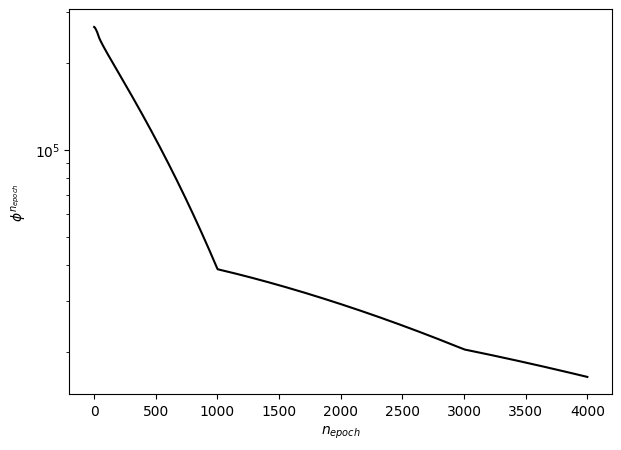

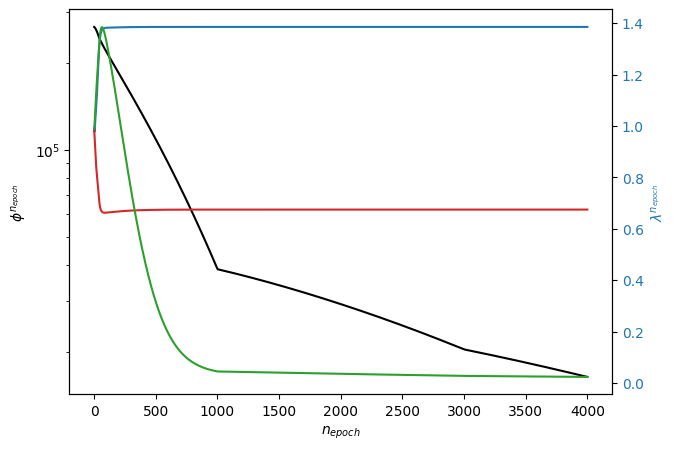

In [13]:
solver.plot_solution();
solver.plot_loss_history();
solver.plot_loss_and_param();